This is a fairly shorthand attempt at deriving the linear weights used in FanGraphs' WAR calculations.  WAR is basically a way to assess a player's contribution to the team in terms of wins.  That is, if a player is worth 5 wins, a team would theoretically lose 5 more games if that player was replaced by an average AAA player.  As a rule of thumb, an average starter is worth about 2 wins while an MVP-caliber season is typically around 7+ wins.  

WAR attempts to encompass a player's contributions at the plate, in the field, and on the basepaths by converting each of those main components into weighted runs and then combining them all together.  For offensive value, this starts with a player's weighted on-base average (wOBA).  wOBA includes run values for things like walks, singles, doubles, triples, and home runs and also adjusts them to factor in what park that player plays in.  You need to do this because a player from Colorado, for example, is generally going to produce a lot more at the plate because it's a much easier place to hit. On the other hand, players in San Diego and San Francisco tend to do worse.  

The first thing to do is import the necessary libraries and the data we are going to be using.  The dataset below consists of every player's overall line for the season as of 9/25 (with a cutoff set to 200 PA).  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as  plt
from scipy.stats.stats import pearsonr

from sklearn import linear_model
from sklearn import svm, preprocessing, cross_validation
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

C:\Users\jfahe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('FanGraphsPos.csv')
df.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR,playerid
0,Jose Altuve,Astros,147,639,24,106,80,32,8.9 %,13.0 %,...,0.348,0.412,0.555,0.408,161,3.5,52.0,-0.5,7.3,5417
1,Aaron Judge,Yankees,149,651,48,122,105,8,18.3 %,31.0 %,...,0.281,0.416,0.610,0.422,167,-1.1,52.5,-1.5,7.3,15640
2,Anthony Rendon,Nationals,142,584,24,76,96,7,13.9 %,13.7 %,...,0.299,0.401,0.532,0.392,141,1.8,32.7,15.6,6.7,12861
3,Giancarlo Stanton,Marlins,152,661,57,118,126,2,12.7 %,23.4 %,...,0.280,0.378,0.635,0.412,158,-2.2,47.0,-2.3,6.6,4949
4,Kris Bryant,Cubs,146,647,28,108,72,7,14.4 %,19.0 %,...,0.294,0.408,0.536,0.398,146,4.7,42.5,1.9,6.5,15429


In [3]:
df.columns

Index(['Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%', 'K%', 'ISO',
       'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off', 'Def',
       'WAR', 'playerid'],
      dtype='object')

Before we do anything, we'd do well to clean up BB% and K% so they're in a format we can actually use; Pandas is reading them as string values because of the space between the numbers and the percentage signs.

In [4]:
BB_fix = []
K_fix = []

for i in df['BB%']:
    new = float(i[0:4])
    BB_fix.append(new)
    
for j in df['K%']:
    new = float(j[0:4])
    K_fix.append(new)

In [5]:
df['BB%'] = BB_fix
df['K%'] = K_fix

Luckily for us, FanGraphs does a pretty good job of keeping their data clean.  That means we don't really need to go hunting for errors.  

For fun, let's just get a feel for the distribution of player WAR by making some visualizations.  

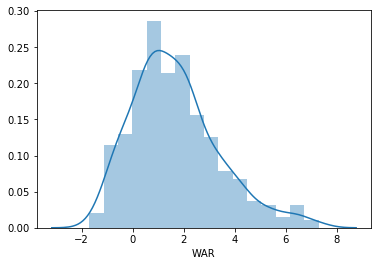

In [6]:
sb.distplot(df['WAR'])
plt.show()

As I said before, average starters tend to be somewhere in the 2-win range while the Aaron Judges and Mike Trouts of the league are way to the right of the distibution in the 6-8 range.

Before we do anything else, let's go ahead and drop the variables we know we won't need (Name, Team, and playerid).  I'm also going to drop Off, wOBA, and wRC+ because the whole point of this is really to see if I can recreate the offensive portion of WAR.  I would also do the same for defense and baserunning, but I don't have the data to derive those in this set.  For now, I'll settle for deriving the overall weights of their overall contributions.

In [7]:
df_clean = df.drop(['Name','Team','Off','wOBA','wRC+','playerid'],axis = 1)

In [8]:
df_clean.describe()

,G,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,BsR,Def,WAR
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,116.668622,446.683284,15.759531,56.451613,54.143695,6.460411,8.701173,20.943695,0.176035,0.303827,0.261100,0.331158,0.437132,-0.036950,-0.609384,1.672434
std,26.409978,138.286146,9.936901,23.145096,24.849190,8.191946,3.158518,5.987428,0.058874,0.035565,0.030826,0.035304,0.071023,2.999929,7.024464,1.713666
min,48.000000,200.000000,0.000000,13.000000,10.000000,0.000000,2.200000,8.400000,0.044000,0.200000,0.173000,0.244000,0.237000,-9.500000,-19.400000,-1.700000
25%,96.000000,326.000000,8.000000,39.000000,35.000000,1.000000,6.300000,16.300000,0.133000,0.279000,0.241000,0.309000,0.389000,-2.000000,-5.100000,0.500000
50%,122.000000,453.000000,14.000000,54.000000,52.000000,4.000000,8.300000,20.800000,0.173000,0.304000,0.262000,0.329000,0.430000,-0.100000,-0.700000,1.400000
75%,139.000000,563.000000,22.000000,74.000000,71.000000,9.000000,10.900000,24.200000,0.217000,0.331000,0.280000,0.354000,0.482000,2.000000,4.100000,2.500000
max,156.000000,699.000000,57.000000,134.000000,126.000000,58.000000,19.100000,37.600000,0.392000,0.394000,0.348000,0.452000,0.684000,10.300000,21.100000,7.300000


Now let's take a look at how all of the columns correlate.  We'll do this with a correlation heatmap.  Lighter cells correlate mean the two variables correlate strongly while darker ones don't really have much of a linear relationship.  

If you look at the last row, we can see that most of the variables we kept seem to be pretty strongly correlated with WAR.  Just by looking at it, we can see that K% doesn't appear to matter at all.  We can also see that some variables are a bit redundant; there's no reason to keep SB as long as we're also keeping BsR. Games played would also contain a lot of the same information as PA while being less informative, so we'll drop that too.  ISO is just SLG - AVG, so we don't really need that either.  I'm tempted to drop BABIP, but I'm also curious how much of an effect it has even if it doesn't have a whole lot of predictive value on its own.

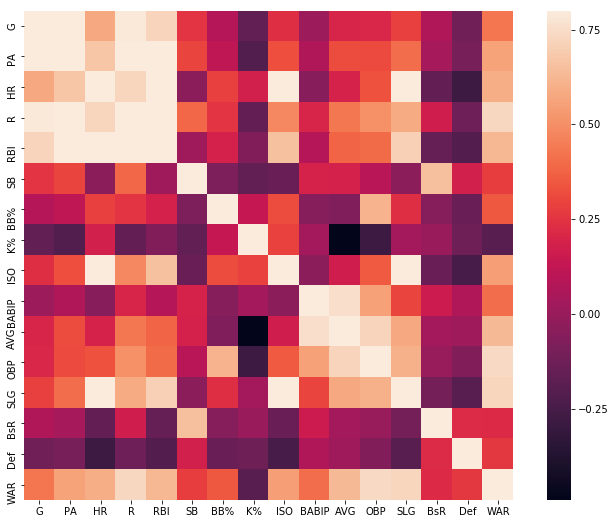

In [9]:
corrmat = df_clean.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [10]:
df_clean = df_clean.drop(['G','SB','K%','ISO','PA'],axis = 1)

Next, we have to convert our data into an array format, scale it, and separate our training and testing sets.  The scaling part is kind of important; it basically takes each variable and converts it to a standardized scale so that you don't have really huge values throwing off your predictions (e.g. Aaron Judge's HR total).  Standardizing something means you're centering its mean at zero and coverting the values to increments of standard deviations, meaning that you now have how many standard deviations above or below the mean a player is in that particular category.  

In [11]:
X = np.array(df_clean.drop(['WAR'],1))
X = preprocessing.scale(X)
y = np.array(df_clean.WAR)

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.3)

Now we're ready to generate some models.  I already know that they're using a linear model, but I thought it'd be fun to also try some other algorithms just to see how they do.  In order, we have a basic linear model, a support vector machine with a linear kernel, a decision tree, a Multilayer Perceptron, a Random Forest set to 100, and a K Nearest Neighbors set to 15.  

In [13]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_test,y_test))

0.914743398934


In [14]:
clf = svm.SVR(kernel = 'linear')
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))

0.914097885082


In [15]:
dt = tree.DecisionTreeRegressor()
dt.fit(X_train,y_train)
print(dt.score(X_test,y_test))

0.760642044637


In [16]:
nn = MLPRegressor()
nn.fit(X_train,y_train)
print(nn.score(X_test,y_test))

0.941786346787


C:\Users\jfahe\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [17]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))

0.886402265479


In [18]:
knn = KNeighborsRegressor(15)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.84955417410307699

It looks like most of them did pretty well; we were able to get a hair above 90% accuracy with a linear model.  Not bad for a first try.  Let's see what the linear weights for each one look like.  

In [19]:
coef_list = list(lm.coef_)
col_list = list(df_clean.columns)
col_list = col_list[0:10]
weight_df = pd.DataFrame(columns=['Variable','Weight'])
weight_df['Variable'] = col_list
weight_df['Weight'] = coef_list

In [20]:
weight_df

,Variable,Weight
0,HR,0.747938
1,R,0.250852
2,RBI,-0.072632
3,BB%,-0.013948
4,BABIP,-0.077467
5,AVG,0.295354
6,OBP,0.700872
7,SLG,0.157488
8,BsR,0.292029
9,Def,0.706458


So there you have it.  Those are the linear weights assigned to each of the variables.  These weights basically mean that for every unit increase in the variable (after we've scaled it), you're adding that much value to a player's WAR.  For example, a player one standard deviation above the mean for home runs is getting an additional .75 wins towards his WAR total.

We could derive more accurate weights by reconfiguring our variables to consist of only things that we know are in their offensive value calculations, but this is a decent start.  I think a fun direction to go from here would be to do the entire thing from the ground up and calculate our own wOBA and then use that to derive the actual weighted runs, but I'll save that for another time.